# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжение поступили исторические данные: технические характеристики, комплектации и цены автомобилей. Задача - построить модель для определения стоимости. 

**Заказчику важны:**

- качество предсказания;
- скорость предсказания;
- время обучения.



**Описание данных:**

Признаки:
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя


Целевой признак:
* Price — цена (евро)


## Подготовка данных

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

### Загрузка данных

In [2]:
# загрузка данных
df = pd.read_csv('/datasets/autos.csv')

### Просмотр данных 

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
# отобразим общую информацию
display(df.info())
print('_' * 40, '\n')

# % пропущенных значений в каждом столбце
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing}).set_index('column_name', drop=True)
display(missing_value_df.sort_values(by='percent_missing', ascending=False))
print('_' * 40, '\n')

# дубликаты в данных
dup = df.duplicated().sum()
print('Дубликаты в данных:', dup)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


None

________________________________________ 



,percent_missing
column_name,
NotRepaired,20.079070
VehicleType,10.579368
FuelType,9.282697
Gearbox,5.596709
Model,5.560588
DateCrawled,0.000000
Price,0.000000
RegistrationYear,0.000000
Power,0.000000


________________________________________ 

Дубликаты в данных: 4


In [5]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Вывод по первичному просмотру данных:

1. В датафрейме имеется большое количество пропусков для следующих признаков:

    * NotRepaired - 20%

    * VehicleType - 10.57%

    * FuelType - 9.3%

    * Gearbox - 5.6%

    * Model - 5.6%


2. В данных присутствуют дубликаты.

3. Некоторые признаки имеют выбросы (`Год регистриации`, `Мощность`)

4. Признак `Количество фото` не содержит никакой информации и полностью состоит из нулей.



### Обработка дубликатов 

In [6]:
# избавимся от дубликатов
df.drop_duplicates(inplace=True)

### Обработка пропусков

In [7]:
# пропуски носят характер MCAR и дабы не потерять данные, заменим NaN обозначением 'undefined'
df_cleaned = df.fillna('undefined')

### Обработка выбросов

#### Признак - Год регистрации автомобиля "RegistrationYear"

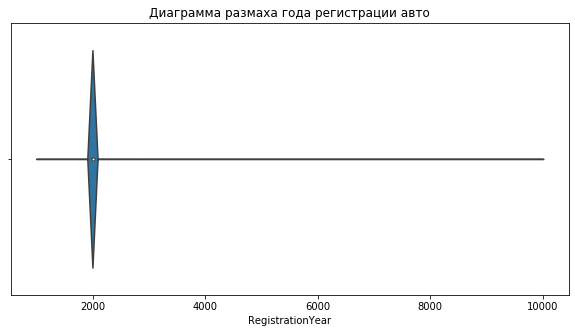

In [8]:
plt.figure(figsize=(10,5))
sns.violinplot(x='RegistrationYear', data=df_cleaned)
plt.title('Диаграмма размаха года регистрации авто')
plt.show()

In [9]:
# Напишем функцию для удаления выбросов
def quantile_clean(df: pd.DataFrame, prefics: str, percent_to_delete: float):
    """
    Удаляет выбросы по заданным персентилями пороговым значениям.
    Возвращает датафрейм с очищенным признаком и печатает количество удалённых строк. 
    
    - df: Датафрейм
    - prefics: Название столбца, в котором требуется удалить выбросы (в строковом формате)
    - percent_to_delete: Процент удаляемых данных.
    """
    original_lenght = df.shape[0]
    
    low_border = percent_to_delete
    high_border = 1 - percent_to_delete
    df = df[(df[prefics] >= df[prefics].quantile(low_border)) & 
                              (df[prefics] <= df[prefics].quantile(high_border))]
    
    lenght_after = original_lenght - df.shape[0]
    print('Было удалено {} строк, {:.3%}'.format(lenght_after, lenght_after / original_lenght))
    
    return df

Было удалено 482 строк, 0.136%


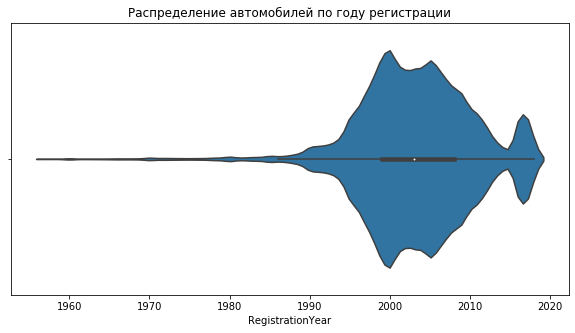

In [10]:
df_cleaned = quantile_clean(df_cleaned, 'RegistrationYear', 0.001)

plt.figure(figsize=(10,5))
sns.violinplot(x='RegistrationYear', data=df_cleaned)
plt.title('Распределение автомобилей по году регистрации')
plt.show()

#### Признак - Мощность двигателя "Power"

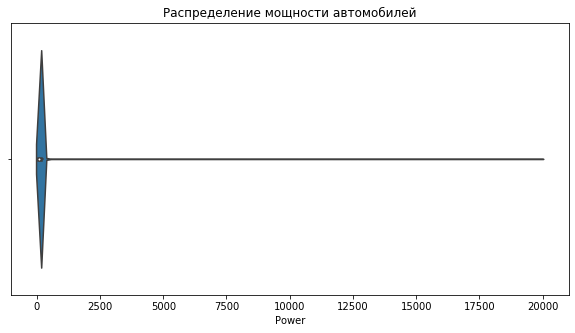

In [11]:
plt.figure(figsize=(10,5))
sns.violinplot(data=df_cleaned, x='Power')
plt.title('Распределение мощности автомобилей')
plt.show()

Было удалено 615 строк, 0.196%


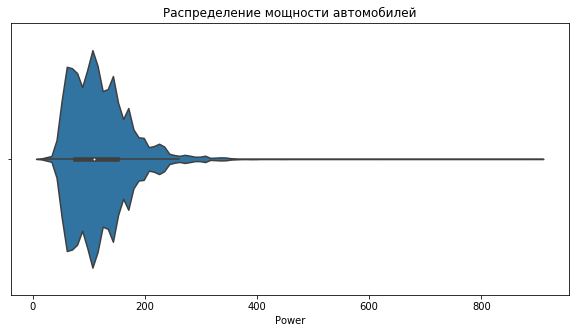

In [12]:
df_cleaned = quantile_clean(df_cleaned.query('Power > 0'), 'Power', 0.001)

plt.figure(figsize=(10,5))
sns.violinplot(data=df_cleaned, x='Power')
plt.title('Распределение мощности автомобилей')
plt.show()

In [13]:
df_cleaned.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,313354.000000,313354.000000,313354.000000,313354.000000,313354.000000,313354.0,313354.000000
mean,4705.280172,2003.270190,120.359265,128595.741557,5.935533,0.0,51027.658785
std,4590.594771,6.901401,54.374202,36692.619380,3.615453,0.0,25795.335228
min,0.000000,1957.000000,15.000000,5000.000000,0.000000,0.0,1067.000000
25%,1250.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30853.000000
50%,2999.000000,2003.000000,110.000000,150000.000000,6.000000,0.0,49828.000000
75%,6890.000000,2008.000000,150.000000,150000.000000,9.000000,0.0,71665.000000
max,20000.000000,2018.000000,902.000000,150000.000000,12.000000,0.0,99998.000000


### Прведение признаков к численному формату и отбор признаков

In [14]:
# удалим признаки, которые не будут использоваться для обучения
df_cleaned = df_cleaned.drop(['DateCrawled', 'DateCreated', 
                              'NumberOfPictures', 'PostalCode', 
                              'LastSeen'], axis=1)

In [15]:
# с помощью OrdinalEncoder переведём категориальные переменные в числовые.
for_ordinal = ['VehicleType', 'Brand', 'Model', 'FuelType', 'Gearbox', 'NotRepaired']
ordinal_enc = OrdinalEncoder()
df_cleaned.loc[:, for_ordinal] = ordinal_enc.fit_transform(df_cleaned.loc[:, for_ordinal])

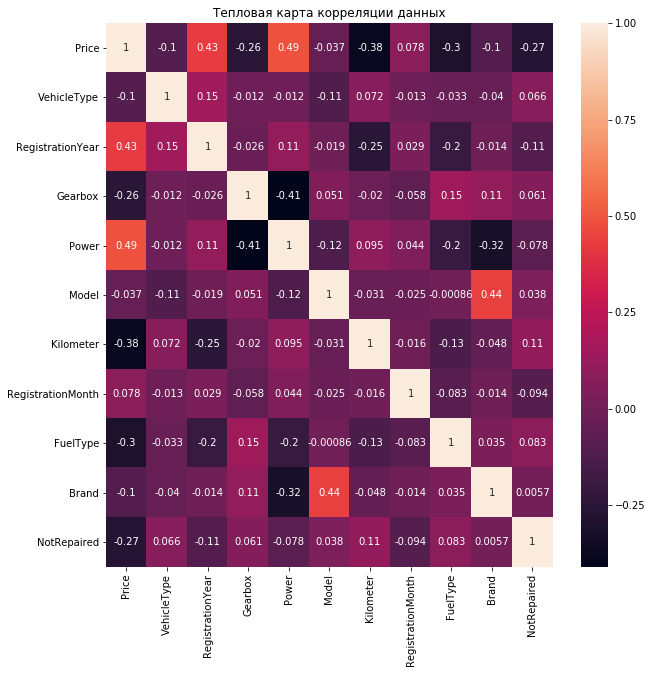

In [16]:
plt.figure(figsize=(10,10))
corr = df_cleaned.corr()
sns.heatmap(corr, annot=True)
plt.title('Тепловая карта корреляции данных')
plt.show()

In [17]:
for_ohe = ['Gearbox', 'NotRepaired', 'VehicleType', 'Brand', 'Model', 'FuelType']

def ohe_encode_concat(df: pd.DataFrame, features_to_encode: list):
    """
    Растягивает категориальные переменные методом One-Hot-Encoding.
    Возвращает начальный датафрейм уже с преобразованными данным.
    """
    
    dummies = pd.get_dummies(data=df, columns=features_to_encode, drop_first=True)
    result = pd.concat([df, dummies], axis=1)
    result = result.drop(features_to_encode, axis=1)
    return result

df_for_linear = ohe_encode_concat(df_cleaned, for_ohe)

In [18]:
# приведём данные для обучения к типу np.array
X_linear = df_for_linear.drop('Price', axis=1).values

X_tree = df_cleaned.drop('Price', axis=1).values

# таргет
y = df_cleaned['Price'].values

In [19]:
X_linear_train, X_linear_test, \
y_linear_train, y_linear_test = model_selection.train_test_split(X_linear, y, test_size=0.2, 
                                                                 random_state=42, shuffle=True)
X_tree_train, X_tree_test, \
y_tree_train, y_tree_test = model_selection.train_test_split(X_tree, y, test_size=0.2, 
                                                             random_state=42, shuffle=True)

X_linear_train.shape, X_linear_test.shape, y_linear_train.shape, y_linear_test.shape

((250683, 315), (62671, 315), (250683,), (62671,))

In [20]:
# удалим лишние переменные
del df_cleaned, df_for_linear, X_linear, X_tree


## Обучение моделей

In [21]:
# RMSE
def score_func(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse = make_scorer(score_func, greater_is_better=False)

rand = 42

# зададим разбиение выборки для кросс-валидации
kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=rand)

In [22]:
def add_cv_result_to_df(df: pd.DataFrame, model_name: str, cv_results):
    df.loc[model_name, :] = [np.mean(i) for i in list(cv_results.values())]
    return df

df_res = pd.DataFrame(columns=['fit_time', 'score_time', 'test_score'])

**Линейные модели**

* Линейная регрессия

In [23]:
ridge = Ridge(random_state=rand)
cv_results = model_selection.cross_validate(ridge, X_linear_train, y_linear_train, cv=4, scoring=rmse)
del ridge
add_cv_result_to_df(df_res, 'Ridge', cv_results)

,fit_time,score_time,test_score
Ridge,5.22898,0.283543,-2655.08


**Модели деревьев**

In [24]:
forest = RandomForestRegressor(random_state=rand)
cv_results = model_selection.cross_validate(forest, X_tree_train, y_tree_train, cv=4, scoring=rmse)
del forest
add_cv_result_to_df(df_res, 'Random Forest', cv_results)

,fit_time,score_time,test_score
Ridge,5.22898,0.283543,-2655.08
Random Forest,7.56568,0.322206,-1794.37


In [25]:
xgb = XGBRegressor(random_state=rand)
cv_results = model_selection.cross_validate(xgb, X_tree_train, y_tree_train, cv=4, scoring=rmse)
del xgb
add_cv_result_to_df(df_res, 'XGBoost', cv_results)

[20:25:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:26:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:26:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:26:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,fit_time,score_time,test_score
Ridge,5.22898,0.283543,-2655.08
Random Forest,7.56568,0.322206,-1794.37
XGBoost,12.0583,0.253773,-2020.7


In [26]:
lgbm = LGBMRegressor(random_state=rand)
cv_results = model_selection.cross_validate(lgbm, X_tree_train, y_tree_train, cv=4, scoring=rmse)
del lgbm
add_cv_result_to_df(df_res, 'LGBM', cv_results)

,fit_time,score_time,test_score
Ridge,5.22898,0.283543,-2655.08
Random Forest,7.56568,0.322206,-1794.37
XGBoost,12.0583,0.253773,-2020.7
LGBM,2.56209,0.621101,-1808.32


In [27]:
cat = CatBoostRegressor(verbose=200, random_state=rand)
cv_results = model_selection.cross_validate(cat, X_tree_train, y_tree_train, cv=4, scoring=rmse)
del cat
add_cv_result_to_df(df_res, 'CatBoost', cv_results)

0:	learn: 4504.8863983	total: 84.5ms	remaining: 1m 24s
200:	learn: 1982.9210316	total: 28.2s	remaining: 1m 51s
400:	learn: 1875.0312793	total: 56.5s	remaining: 1m 24s
600:	learn: 1821.1210184	total: 1m 24s	remaining: 56.2s
800:	learn: 1785.8064766	total: 1m 52s	remaining: 28s
999:	learn: 1760.7066626	total: 2m 21s	remaining: 0us
0:	learn: 4501.9720764	total: 94.3ms	remaining: 1m 34s
200:	learn: 1988.4288983	total: 28.4s	remaining: 1m 52s
400:	learn: 1880.6515942	total: 56.1s	remaining: 1m 23s
600:	learn: 1828.0035618	total: 1m 24s	remaining: 56.1s
800:	learn: 1792.3356612	total: 1m 52s	remaining: 28s
999:	learn: 1766.6301487	total: 2m 20s	remaining: 0us
0:	learn: 4519.3297518	total: 28.9ms	remaining: 28.8s
200:	learn: 1998.1953807	total: 28.5s	remaining: 1m 53s
400:	learn: 1889.2967607	total: 56.5s	remaining: 1m 24s
600:	learn: 1834.8774353	total: 1m 25s	remaining: 56.7s
800:	learn: 1799.1042423	total: 1m 53s	remaining: 28.2s
999:	learn: 1772.7776220	total: 2m 21s	remaining: 0us
0:	lea

,fit_time,score_time,test_score
Ridge,5.22898,0.283543,-2655.08
Random Forest,7.56568,0.322206,-1794.37
XGBoost,12.0583,0.253773,-2020.7
LGBM,2.56209,0.621101,-1808.32
CatBoost,144.47,0.296054,-1799.42


In [28]:
df_res['test_score'] = abs(df_res['test_score'])
df_res

,fit_time,score_time,test_score
Ridge,5.22898,0.283543,2655.08
Random Forest,7.56568,0.322206,1794.37
XGBoost,12.0583,0.253773,2020.7
LGBM,2.56209,0.621101,1808.32
CatBoost,144.47,0.296054,1799.42


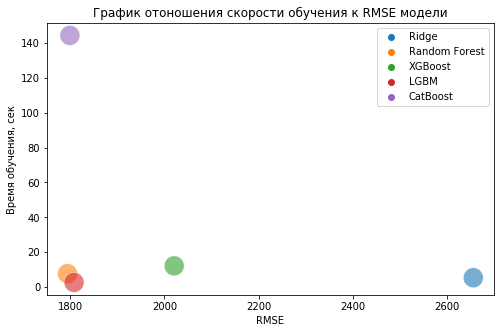

In [29]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=df_res['test_score'], y=df_res['fit_time'], 
                hue=df_res.index, s=400, alpha=0.6)
plt.title('График отоношения скорости обучения к RMSE модели')
plt.xlabel('RMSE')
plt.ylabel('Время обучения, сек')
plt.show()

## Анализ моделей

Лучший результат показала модель `LightGBM`, поэтому далее будем использовать её. Настроим гиперпараметры и посмотрим, какого качества сможем добиться.

In [30]:
params = dict(n_estimatores=range(1000, 1500, 100), 
              learning_rate=[0.07, 0.2, 0.4])
lgbm = LGBMRegressor()

rand_search_cv = model_selection.RandomizedSearchCV(lgbm, params, 
                                                    scoring=rmse, 
                                                    random_state=rand)

In [31]:
search = rand_search_cv.fit(X_tree_train, y_tree_train)

In [32]:
print(search.best_params_)
print(search.best_score_)

{'n_estimatores': 1100, 'learning_rate': 0.4}
-1753.4742907354644


In [33]:
lgbm = LGBMRegressor(n_estimators=1100, learning_rate=0.4)
lgbm.fit(X_tree_train, y_tree_train)
predictions = lgbm.predict(X_tree_test)
score = np.sqrt(mean_squared_error(y_tree_test, predictions))
print('Финальный оценка модели на тестовой выборке: {:.2f}'.format(score))

Финальный оценка модели на тестовой выборке: 1660.49


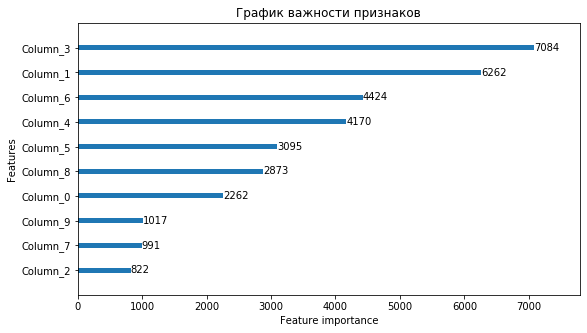

In [34]:
from lightgbm import plot_importance

plot_importance(lgbm, figsize=(9, 5), grid=False)
plt.title('График важности признаков')
plt.show()

### Вывод:

* Лучший результат по скорости работы и итоговой метрике показала модель __LGBMRegressor__. Значение **RMSE** = 1660.49

* Наиболее важными факторами для итоговой модели являются **мощность двигателя** и **год регистрации авто**.